In [1]:
%pylab inline
import numpy as np
import gym
from gym import spaces
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
class AgentEnv(gym.Env):
    metadata = {
        'render.modes': ['human']
    }
    def __init__(self):
        self.T_min = 20
        self.T_max = 80
        self.T = self.T_max - self.T_min
        self.reset()
        
        self.action_space = spaces.Box(
            low=0.00001,
            high=self.state[1],
            shape = (1,),
            dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=0,
            high=1000,
            shape = (2,),
            dtype=np.float32
        )
        self.reset()
     
    def u(self,c):
        gamma = 2
        return (np.float_power(c, 1-gamma) - 1)/(1 - gamma)
    
    def step(self, action):
        c = action
        r = 0.02
        done = bool(
            self.state[0] == self.T_max-1
        )
        self.state[0] += 1
        
        c = action
        t = self.state[0]
        if done:
            reward = (100000*self.u(self.state[1])) *((1/1.02)**(-t))
        else:
            if c > self.state[1] or c <=0:
                reward = -1000000000
            else:
                reward = (self.u(c)) * ((1/1.02)**(-t))
            
        self.state[1] = (self.state[1] - c)*(1+r)
        
        return self.state, float(reward), done, {}
    
    def reset(self):
        self.age = self.T_min
        self.state = np.array([self.T_min,100+numpy.random.random()])
        return np.array(self.state)
    
    def render(self):
        pass

In [3]:
from stable_baselines3.common.env_checker import check_env
env = AgentEnv()
# It will check your custom environment and output additional warnings if needed
check_env(env)

In [4]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import Adam, RMSprop


def OurModel(input_shape, action_space):
    X_input = Input(input_shape)

    # 'Dense' is the basic form of a neural network layer
    X = Dense(4, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X_input)

    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name='model1')
    
    model.compile(loss="mse", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model

In [5]:
%%time
from stable_baselines3 import A2C
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=10000)

CPU times: user 1min 1s, sys: 150 ms, total: 1min 2s
Wall time: 1min


In [12]:
state = env.reset()
total = 0
C = []
S = []
for i in range(1000):
    action, _state = model.predict(state)
    state, reward, done, info = env.step(action)
    total += reward 
    C.append(action[0])
    S.append(state[1])
    if done:
        print(total)
        env.reset()
        break

-12999498564.106344


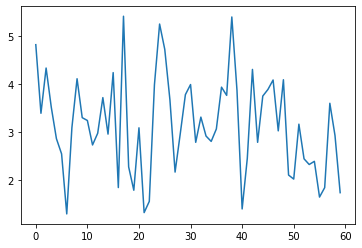

In [7]:
plt.plot(C)

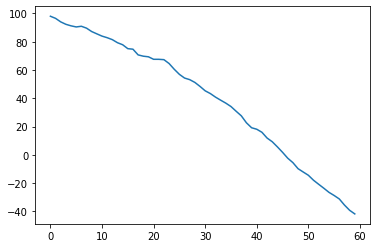

In [8]:
plt.plot(S)

In [9]:
model2 = A2C('MlpPolicy', env, verbose=0)
state = env.reset()
total = 0
C = []
S = []
for i in range(1000):
    action, _state = model2.predict(state)
    state, reward, done, info = env.step(action)
    total += reward 
    C.append(action[0])
    S.append(state[1])
    if done:
        print(total)
        env.reset()
        break

-9784116.85588728


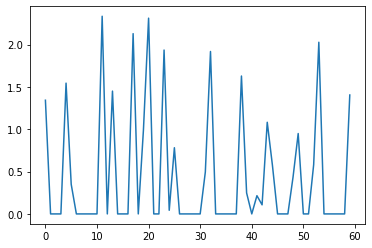

In [10]:
plt.plot(C)

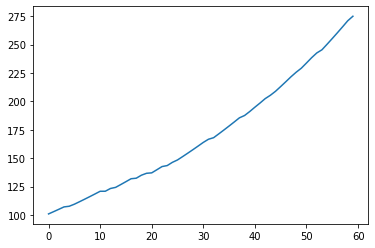

In [11]:
plt.plot(S)